In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from scipy import stats
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
import joblib

In [2]:
df = pd.read_csv('car_prices.csv')

In [3]:
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [4]:
df.isnull().sum()

year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65352
vin                 4
state               0
condition       11820
odometer           94
color             749
interior          749
seller              0
mmr                38
sellingprice       12
saledate           12
dtype: int64

In [5]:
df = df.drop(columns='vin')
df = df.drop(columns='saledate')    
df = df.drop(columns='seller')    
df = df.drop(columns='trim')    
df = df.drop(columns='model')    

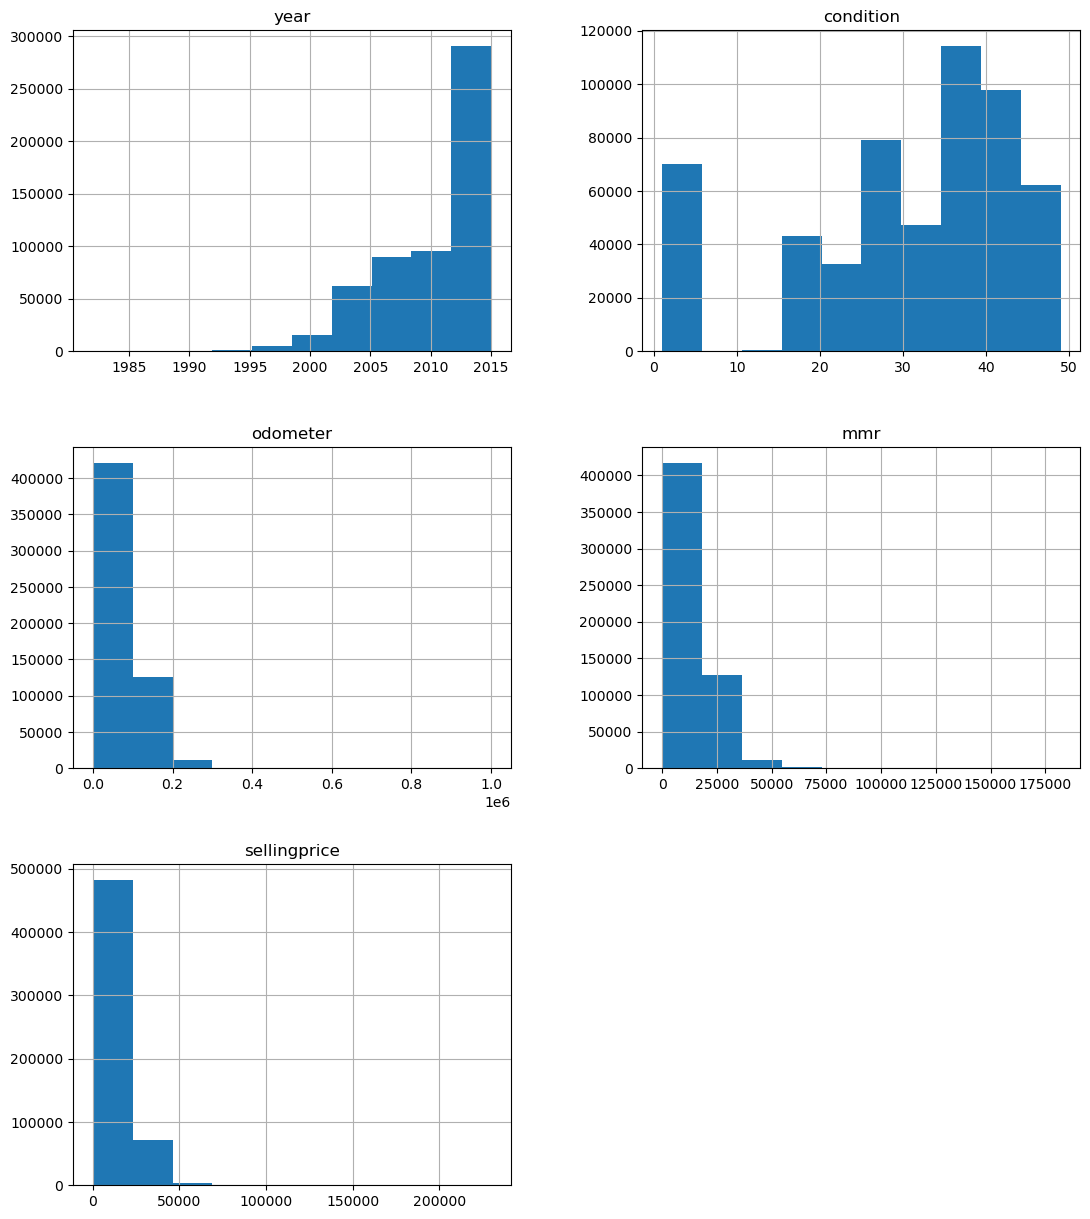

In [6]:
df.hist(figsize=(13, 15))
plt.show()

# Removing Outlier & Null Data

In [7]:
df.dtypes

year              int64
make             object
body             object
transmission     object
state            object
condition       float64
odometer        float64
color            object
interior         object
mmr             float64
sellingprice    float64
dtype: object

In [8]:
numeric_features = df.select_dtypes(include=['float', 'int']).columns
numeric_features

Index(['year', 'condition', 'odometer', 'mmr', 'sellingprice'], dtype='object')

In [9]:
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].mean())

In [10]:
category_features = df.select_dtypes(include=['object']).columns
category_features

Index(['make', 'body', 'transmission', 'state', 'color', 'interior'], dtype='object')

In [11]:
df[category_features] = df[category_features].fillna(df[category_features].mode().iloc[0])

In [12]:
df.isnull().sum()

year            0
make            0
body            0
transmission    0
state           0
condition       0
odometer        0
color           0
interior        0
mmr             0
sellingprice    0
dtype: int64

Text(0.5, 1.0, 'Correlation Matrix')

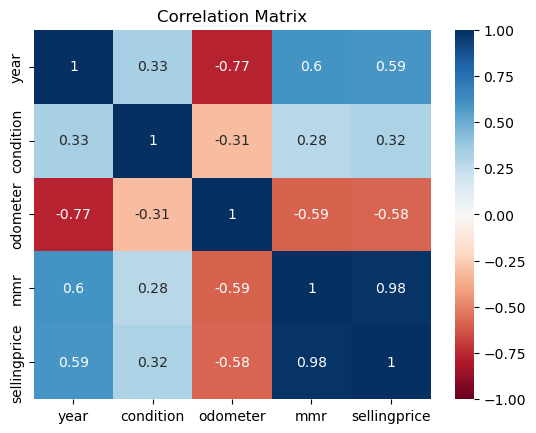

In [13]:
float_int_cols = df.select_dtypes(include=[np.float64, np.int64]).columns
corr = df[float_int_cols].corr()
sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax=1, annot=True, )
plt.title('Correlation Matrix')

d:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


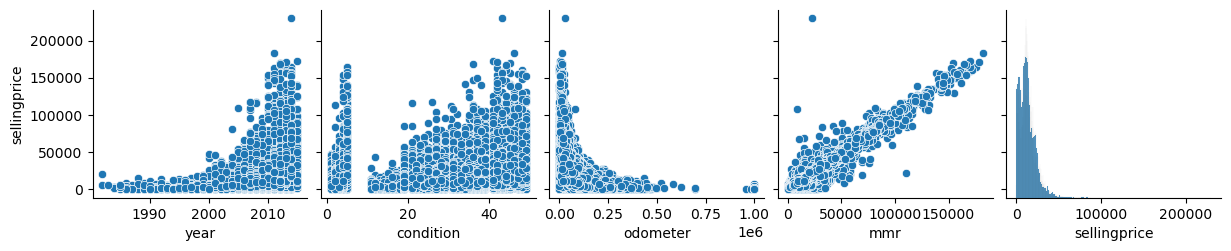

In [14]:
sns.pairplot(data=df, y_vars='sellingprice')
plt.show()

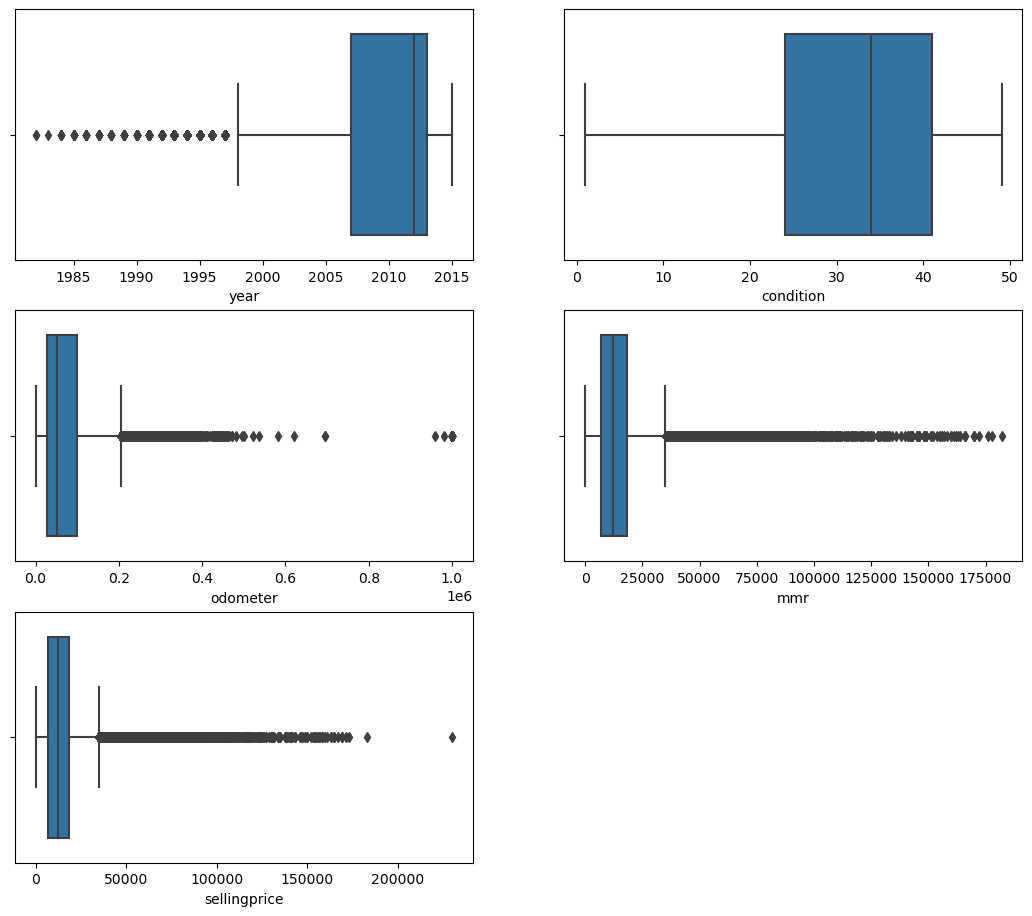

In [15]:
plt.figure(figsize=(13, 15))
for i, feature in enumerate(numeric_features, 1):
    sns.boxplot(x=feature, data=df, ax=plt.subplot(4, 2, i)) 

## Cleaning outliers in numeric feature

In [16]:
def cleaning_numeric_data(df):
    for feature in numeric_features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        df[feature] = np.where((df[feature] < lower_bound) | (df[feature] > upper_bound),
                                 df[feature].mean(), df[feature])
    return df
cleaned_df = cleaning_numeric_data(df)

# Encoding Categorical Feature & Normalize Numeric Feature

In [17]:
def encoding_normalize_categorical_data(df):
    label = LabelEncoder()
    encoded_normalize_df = df.copy()
    for feature in df[category_features]:
        encoded_normalize_df[feature] = label.fit_transform(encoded_normalize_df[feature]) 
    for feature in df[numeric_features]:
        scaler = MinMaxScaler()
        encoded_normalize_df[feature] = scaler.fit_transform(df[[feature]])
    return encoded_normalize_df

In [18]:
normalized_encoded_df = encoding_normalize_categorical_data(cleaned_df)
normalized_encoded_df

,year,make,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice
0,1.000000,24,36,1,29,0.083333,0.081085,43,1,0.583749,0.612525
1,1.000000,24,36,1,29,0.083333,0.045772,43,0,0.592302,0.612525
2,0.941176,3,37,1,29,0.916667,0.006482,33,1,0.908767,0.854697
3,1.000000,51,37,1,29,0.833333,0.069599,43,1,0.783321,0.790592
4,0.941176,3,37,1,29,0.875000,0.012866,33,1,0.391857,0.387771
...,...,...,...,...,...,...,...,...,...,...,...
558832,1.000000,24,37,1,35,0.916667,0.088961,41,1,0.391857,0.940169
558833,0.823529,41,11,1,62,0.083333,0.265080,43,1,0.860299,0.877489
558834,0.823529,3,36,1,29,0.979167,0.246405,27,1,0.848895,0.968660
558835,1.000000,36,78,1,32,0.770833,0.081178,43,1,0.429793,0.316220


# Splitting Independent and Dependent Variable

In [19]:
X = normalized_encoded_df.iloc[:, [0,1,2,3,4,5,6,7,8,9]].values
y = normalized_encoded_df.iloc[:, 10].values

In [20]:
X

array([[ 1.        , 24.        , 36.        , ..., 43.        ,
         1.        ,  0.58374911],
       [ 1.        , 24.        , 36.        , ..., 43.        ,
         0.        ,  0.59230221],
       [ 0.94117647,  3.        , 37.        , ..., 33.        ,
         1.        ,  0.90876693],
       ...,
       [ 0.82352941,  3.        , 36.        , ..., 27.        ,
         1.        ,  0.84889522],
       [ 1.        , 36.        , 78.        , ..., 43.        ,
         1.        ,  0.4297933 ],
       [ 0.94117647, 14.        , 39.        , ..., 33.        ,
         6.        ,  0.84319316]])

In [21]:
y

array([0.61252457, 0.61252457, 0.85469672, ..., 0.96866008, 0.31621984,
       0.76067694])

# Model XGBOOST 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
regressor = XGBRegressor()

In [24]:
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

In [25]:
predict  = pd.DataFrame(predictions)
ytest = pd.DataFrame(y_test)
resultant = pd.concat([predict, ytest], axis=1)

In [26]:
resultant.columns=['Predicted_values','Actual_values']

In [27]:
resultant.head()

,Predicted_values,Actual_values
0,0.034824,0.014929
1,0.149753,0.159520
2,0.682625,0.689450
3,0.307649,0.319069
4,0.027954,0.028462


In [28]:
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mean_squared_error(y_test, predictions))
print(f'mae: {mae}, mse: {mse}, rmse: {rmse}')

mae: 0.02824880161991401, mse: 0.0026841871290992046, rmse: 0.05180914136616437


In [29]:
r2 = r2_score(y_test, predictions)
print(r2)

0.9431119898305096


In [30]:
# joblib.dump(regressor, 'xgboost_vehicle_price_prediction_model.pkl')